# Calibration d'un simulateur multi agents sur des données réelles

Team : CRISTAL Lab, SMAC team, Lille University

Entreprise Collaboratrice : fifty-five, 5-7 rue d'Athènes, Paris

Contact : jarod.vanderlynden@fifty-five.com, philippe.mathieu@univ-lille.fr, romain@fifty-five.com

Création : 28/02/2025

## Introduction

Cette feuille Jupyter reproduit les résultats présentés dans l'article "_Calibration d’un Système Multi-Agent pour
l’Optimisation des Prix de Produits Concurrentiels_". 

### Présentation du modèle

Dans un premier temps nous présentons rapidement le modèle. C'est le même modèle que celui présenté dans le notebook "_FR_Get_Started_Decoy_Effect_". Dans ce modèle, nous n'observons qu'une catégorie de produit. Une catégorie de produit est définie comme un ensemble de produits en concurrence directe. Ce modèle simule la présentation d'une catégorie de produits à un ensemble de clients, puis chacun des clients choisit un produit. Les agents sont des abstractions des clients, ils disposent de paramètres internes qu'ils utilisent pour faire leurs choix. Le processus de décision des agents est le même pour tous. On ne cherche pas à simuler les nombre d'acheteurs potentiels.

Nous avons montré que ce modèle était capable de reproduire des faits stylisés marketing tel que l'effet de leurre de similarité et de compromis. Ces effets également appelés effets de contexte son des effets que nous avons réussi a reproduire en implémentant un unique biais psychologique chez nos agents : l'aversion à la perte. 

In [2]:
import pandas as pd
from datetime import datetime, date, timedelta
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time

***

### Description du modèle

Dans cette partie nous décrivons le modèle et son implémentation. Nous passerons rapidement sur le fonctionnement du modèle, un notebook : "_FR_Get_Started_Decoy_Effect_", détaille le fonctionnement du modèle.

***

### Calibration 

Dans cette partie nous détaillerons la calibration du modèle. 

Dans un premier temps nous récupérons les informations sur nos produits. Ils sont ici encodés "à la main" afin de ne pas avoir à acceder aux fichiers de données que nous ne pouvons rendre public.

In [5]:
# Définition d'un dataframe de produits.
df_products = pd.DataFrame()
df_products["name"] = np.array(['45 OUTILS', '108 OUTILS',
       '111 OUTILS MALLETTE',
       '40 OUTILS BOITE'])
df_products["prix"] = [49.90, 59.90, 99.90, 49.40]
df_products["type_boite"] = [0, 2, 3, 1]
df_products["nb_outils"] = [45, 108, 111, 40]
# Normalisation entre 0 et 1
for name in ["prix", "type_boite", "nb_outils"]:
    x, y = df_products[name].min(), df_products[name].max()
    df_products[name] = (df_products[name] - x)/(y-x)

true_sales_sorted =  [54, 295, 161, 131] # Cette variable représente les ventes réelles de nos différents produits, trié selon l'ordre "P1, P2, P3, P4"

On crée une distribution de revenus grâce à des données INSEE : _https://www.insee.fr/fr/statistiques/7707884#onglet-1_, données, figure 2

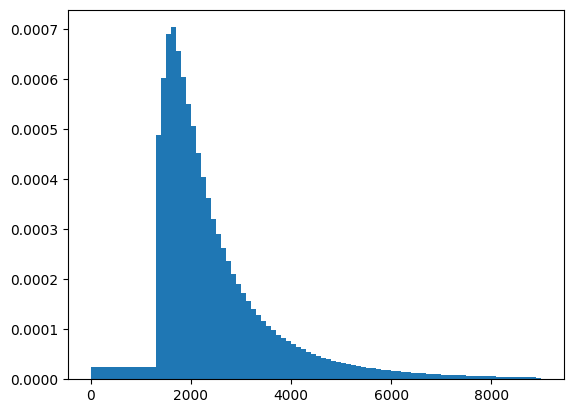

In [8]:
distrib_revenues = np.array([531,832,1027,1174,1198,1116,1030,938,861,770,688,616,547,495,447,402,359,323,294,266,240,220,200,183,168,152,139,130,
                             120,110,102,94,85,79,74,69,63,59,56,51,47,44,42,39,37,34,32,30,29,27,25,24,22,21,20,
                             19,18,17,16,15,14,13,13,12,12,11,11,10,10,9,9,8,8,8,7,7,7,6])
bins=[0,1300,1400,1500,1600,1700,1800,1900,2000,2100,2200,2300,2400,2500,2600,2700,2800,2900,3000,3100,3200,3300,3400,
      3500,3600,3700,3800,3900,4000,4100,4200,4300,4400,4500,4600,4700,4800,4900,5000,5100,5200,5300,5400,5500,5600,
      5700,5800,5900,6000,6100,6200,6300,6400,6500,6600,6700,6800,6900,7000,7100,7200,7300,7400,7500,7600,7700,7800,
      7900,8000,8100,8200,8300,8400,8500,8600,8700,8800,8900,9000]
density = plt.hist(bins[:-1], bins, weights=distrib_revenues, density=True)
density[0][0] = density[0][0]*13

Maintenant on définit une fonction de génération de sensibilité à la qualité pour nos agents. Le processus, aussi décrit dans l'article, est le suivant : La sensibilité à la qualité $S_Q$ de nos agents est représentée par un réel compris entre 0 et 1. 0 étant une sensibilité nulle à la qualité et 1 une sensibilité maximale. Pour obetenir cette sensibilité, nous utilisons un tirage suivant une loi normale de moyenne $\mu$ et d'écart-type $\sigma$. 

Les agents sont répartis en trois catégories ayant chacune une valeur de $\mu$ et $\sigma$ différente. La répartition des agents dans ces catégories est faite en s'appuyant sur un questionnaire réalisé auprès des clients de cette entreprise. Les clients avaient droit à plusieurs réponses face à la question "Quels sont vos critères de choix".Trois réponses étaient possible "Le prix le plus bas" 47\% des réponses, "L’esthétique" 7.5\% des réponses et "Le respect des normes de qualité" 45.5\% des réponses. 

Les valeurs utilisées pour $\mu$ selon les catégories sont les suivantes : 
- "Le prix le plus bas" $\mu = 0.1$ 
- "L’esthétique" $\mu = x_4$
- "Le respect des normes de qualité" $\mu = 0.9$

La valeur de $\sigma$ est la même pour toutes les catégories et est laissée libre pour le processus de calibration : $\sigma = x_5$. Les valeurs inférieures à zéro et supérieures à un sont ramenées à ces bornes. La valeur de sensibilité à la qualité d'un agent suit donc une loi normale de moyenne et d'écart-type dépendant de sa catégorie. Les agents sont répartis entre les catégories selon une distribution issues du questionnaire précédent. 

In [42]:
#Format des données à intégrer à notre fonction de génération de sis
data_categories = {
    "Le prix le plus bas": 8846,
    "L'esthétique / Le design": 1426,
    "Le respect des normes de qualité, de sécurité": 8654,
}

sensitivity_weights = {
        "Le prix le plus bas": 0.1, 
        "L'esthétique / Le design": 0, # Entre 0 et 1, paramètre à calibrer.
        "Le respect des normes de qualité, de sécurité": 0.9, 
    }

def generate_quality_sensitivity_distribution(categories, sensitivity_weights, calibration_factor=1.0, size=1000):
    """
    Génère une distribution de sensibilités à la qualité basées sur les catégories et leur importance.

    :param categories: Dictionnaire avec les catégories et leur nombre d'occurrences
    :param sensitivity_weights: Dictionnaire avec les sensibilités moyennes associées aux catégories
    :param calibration_factor: Facteur de calibration pour ajuster la variance
    :param size: Nombre total de sensibilités à générer
    :return: Distribution des sensibilités à la qualité (numpy array)
    """
    size = size+10
    # Normalisation des poids
    total_clients = sum(categories.values())
    category_probabilities = {cat: count / total_clients for cat, count in categories.items()}

    # Initialisation de la liste des sensibilités
    sensitivities = []

    # Calcul du nombre d'échantillons par catégorie, en tenant compte du total à générer
    remaining_samples = size  # Nombre d'échantillons restants à générer

    # Calcul du nombre d'échantillons pour chaque catégorie, ajusté pour éviter les imprécisions
    category_samples = {}
    for category, probability in category_probabilities.items():
        category_samples[category] = round(probability * size)
        remaining_samples -= category_samples[category]

    # Ajuster les échantillons restants pour la dernière catégorie afin de respecter le total
    if remaining_samples > 0:
        # Ajouter les échantillons restants à la catégorie ayant la probabilité la plus élevée
        largest_category = max(category_samples, key=lambda cat: category_probabilities[cat])
        category_samples[largest_category] += remaining_samples

    # Génération des sensibilités pour chaque catégorie
    for category, num_samples in category_samples.items():
        mean_sensitivity = sensitivity_weights.get(category, 0.5)
        std_dev = (1 - mean_sensitivity) * calibration_factor  # Écart type ajusté

        # Génération d'une sous-distribution pour la catégorie
        sub_distribution = np.clip(np.random.normal(mean_sensitivity, std_dev, num_samples), 0, 1)
        sensitivities.extend(sub_distribution)
    size = size - 10 # Due à des erreurs d'imprécisions a cause d'arrondies, nous générons trop de valeurs afin d'être sur d'en avoir tiré assez
    return np.array(sensitivities)[:size]

On définit maintenant la fonction de calibration. L'objectif est de générer une population d'agents, la tester avec notre modèle. On obtiens des ventes qu'on compare avec les ventes réelles, cela nous donne une perte qu'on va pourvoir essayer de minimiser.

In [45]:
def calibration(true_sales_sorted, df_products, nb_agents, x3, x5, 
                     max_revenue, loss_aversion, weights1, weights7):
    # Génération des revenus des agents
    np.random.seed(np.random.randint(5000))
    agents_revenue = np.random.choice(density[1][:-1],nb_agents,p=(density[0]*100))
    agents_revenue[agents_revenue==0]=(1300/2)
    agents_revenue = np.random.normal(agents_revenue,200)
    
    data_categories = {
        "Le prix le plus bas": 8846,
        "L'esthétique / Le design": 1426,
        "Le respect des normes de qualité, de sécurité": 8654,
    }
    
    sensitivity_weights = {
        "Le prix le plus bas": 0.1, 
        "L'esthétique / Le design": weights1, # Entre 0 et 1 
        "Le respect des normes de qualité, de sécurité": 0.9, 
    }

    calibration_factor = weights7 

    # Génération de la sensibilité a la qualité des agents.
    sensi_qual = generate_quality_sensitivity_distribution(data_categories, sensitivity_weights, calibration_factor, size=len(agents_revenue))

    # Création de la qualité des produits, composée des différentes caractéristiques des produits.
    products = np.array([df_products["prix"], np.array(x3 * df_products["type_boite"] + x5 * df_products["nb_outils"])])

    # Création de la sensibilité au prix des agents en utilisant les tirages de revenus réalisés précedemment
    sensi_prix = np.maximum(0, 1-(agents_revenue/max_revenue))
    
    # Création des couples sensibilité prix/qualité qui forment les caractéristiques d'un agent. 
    sensitivity = (np.array([sensi_prix,sensi_qual])).T
    # sensitivity a une taille : (nb_agent, 2) 
    
    # Calcul des caractéristiques du produit de références
    product_ref_prix = products[0].mean()
    product_ref_quality = products[1].mean()

    #Calcul de la fonction d'utilité, on réalise tous les calculs en une fois avec du calcul matriciel. 
    # Initialisation de la matrice des différences (par rapport au produit de référence)
    diffs = products.copy() # Copie pour éviter de modifier `products`
    diffs[0] = -1 * (products[0] - product_ref_prix) # Différence des prix inversée 
    # Un prix élevé est perçu comme négatif et à l'inverse une qualité élevée est perçu comme positif.
    diffs[1] = products[1] - product_ref_quality

    # Application du paramètre d'aversion aux pertes
    diffs_lossed = np.where(diffs<0, diffs * loss_aversion, diffs)
    
    # Préparation pour le calcul matriciel
    diffs_expanded = diffs_lossed.T[:, np.newaxis, :]
    # Transpose `diffs_lossed` pour avoir une shape de (nb_products, 2),  
    # puis ajoute un nouvel axe pour obtenir (nb_products, 1, 2)
    sensitivity_expanded = sensitivity[np.newaxis, : , :]
    # Ajoute un axe pour avoir une shape de (1, nb_agent, 2),  
    # permettant le broadcasting lors de la multiplication
    
    # Calcul de l’utilité en multipliant les différences avec la sensibilité
    utilities = diffs_expanded * sensitivity_expanded
    # Broadcasting : (nb_products, 1, 2) * (1, nb_agent, 2)  
    # Résultat : (nb_products, nb_agent, 2)
    
    utilities = np.sum(utilities, axis=-1)
    # Somme sur la dernière dimension (somme des contributions du prix et de la qualité)  
    # Shape finale : (nb_products, nb_agent)

    # Sélection du produit ayant la meilleure utilité pour chaque agent
    max_values = np.max(utilities, axis=0)
    best_product_indices = np.argmax(utilities, axis=0)  # (num_agents,)

    # Comptabilisation du nombre d’agents choisissant chaque produit
    results = np.unique(best_product_indices, return_counts=True)
    results_sorted = np.zeros(len(true_sales_sorted))
    cpt = 0
    for i in range(len(results_sorted)):
        if cpt>=len(results[0]):
            results_sorted = (results_sorted / np.sum(results_sorted)) * 100
            true_sales_sorted = (true_sales_sorted / np.sum(true_sales_sorted)) * 100
            return np.sum(np.abs(results_sorted - true_sales_sorted))
        if i == results[0][cpt]:
            results_sorted[i] = results[1][cpt]
            cpt+=1
    results_sorted = (results_sorted / np.sum(results_sorted)) * 100
    true_sales_sorted = (true_sales_sorted / np.sum(true_sales_sorted)) * 100
    return np.sum(np.abs(results_sorted - true_sales_sorted))

In [46]:
start_time = time.time()
print(calibration(true_sales_sorted, df_products, 1000, 1, 10, 1000, 10,
                       0.1, 1))
end_time = time.time()
execution_time = end_time - start_time
print(f"Le temps d'exécution de la fonction test_calibration est de {execution_time:.6f} secondes.")

126.1173166926677
Le temps d'exécution de la fonction test_calibration est de 0.004988 secondes.


***

### GridSearch

/!\ L'éxécution des cellules qui suivent peut être long.

In [79]:
from itertools import product
from tqdm import tqdm

def grid_search_calibration(true_sales_sorted, df_products, nb_agents):
    # Définition des grilles de valeurs à tester pour chaque paramètre
    x3_values = np.linspace(0, 0.3, 10)  # 5 valeurs entre 0 et 1
    x5_values = np.linspace(0, 0.3, 10)
    max_revenue_values = np.linspace(1000, 9000, 5)  # 5 valeurs entre 0 et 9000
    loss_aversion_values = np.linspace(0, 10, 5)  # 5 valeurs entre 0 et 10
    w1_values = np.linspace(0, 1, 5)
    w7_values = np.linspace(0, 1, 5)
    
    # Liste de toutes les combinaisons possibles
    param_grid = list(product(x3_values, x5_values, max_revenue_values, 
                              loss_aversion_values, w1_values, w7_values))
    
    best_loss = float('inf')
    best_params = None
    
    # Parcours de toutes les combinaisons avec une barre de progression
    for params in tqdm(param_grid, desc="Calibration en cours"):
        x3, x5, max_revenue, loss_aversion, w1, w7 = params
        
        # Calcul de la fonction de perte
        loss = (calibration(true_sales_sorted, df_products, nb_agents, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, nb_agents, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, nb_agents, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, nb_agents, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, nb_agents, x3, x5, 
                                max_revenue, loss_aversion, w1, w7))/5
        
        # Mise à jour des meilleurs paramètres si meilleure performance
        if loss < best_loss:
            best_loss = loss
            best_params = params
    
    return best_params, best_loss

# Exécution du Grid Search
best_params, best_loss = grid_search_calibration(true_sales_sorted, df_products, 641)
print("Meilleurs paramètres:", best_params)
print("Meilleure perte:", best_loss)


Calibration en cours: 100%|██████████████████████████████| 62500/62500 [1:49:39<00:00,  9.50it/s]


Meilleurs paramètres: (0.0, 0.4444444444444444, 3000.0, 0.0, 1.0, 1.0)
Meilleure perte: 9.672386895475821


In [76]:
x3, x5, max_revenue, loss_aversion, w0, w7 = best_params
print("Optimized Parameters:")
print(f"x3: {x3}, x5: {x5}")
print(f"w0: {w0}, w7: {w7}")
print(f"max_revenue: {max_revenue}, loss_aversion: {loss_aversion}")
print(calibration(true_sales_sorted, df_products, 641, x3, x5,
                            max_revenue, loss_aversion, w0, w7))
print(f"Minimum Loss: {result.fun}")

Optimized Parameters:
x3: 0.0, x5: 0.16666666666666666
w0: 0.75, w7: 0.0
max_revenue: 2777.777777777778, loss_aversion: 2.5
7.800312012480504
Minimum Loss: 0.31201248049922015


***
### Calibration "_differential_evolution_"

On utilise "_differential_evolution_" de la bibliothèque scipy.optimize. Cette calibration est plus rapide, quelque minutes, contre quelque heures pour la calibration Grid Search.

In [83]:
from scipy.optimize import differential_evolution
import numpy as np

# Mise à jour des bornes
bounds = [
    (0, 1),  # x3
    (0, 1),  # x5
    (0, 9000),  # max_revenue
    (0, 10),  # loss_aversion
    (0, 1),   # w1
    (0, 1)    # w7
]

# Fonction d'évaluation
def objective_function(params):
    x3, x5, max_revenue, loss_aversion, w1, w7 = params
    
    # Appeler la fonction de simulation
    loss = (calibration(true_sales_sorted, df_products, 641, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, 641, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, 641, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, 641, x3, x5, 
                                max_revenue, loss_aversion, w1, w7) + calibration(true_sales_sorted, df_products, 641, x3, x5, 
                                max_revenue, loss_aversion, w1, w7))/5
    return loss

# Optimisation par Differential Evolution
result = differential_evolution(objective_function, bounds, strategy='best1bin', maxiter=100, popsize=20, tol=1e-7)

# Résultats
best_params = result.x
x3, x5, max_revenue, loss_aversion, w0, w7 = best_params

print("Optimized Parameters:")
print(f"x3: {x3}, x5: {x5}")
print(f"w0: {w0}, w7: {w7}")
print(f"max_revenue: {max_revenue}, loss_aversion: {loss_aversion}")
print(calibration(true_sales_sorted, df_products, 641, x3, x5,
                            max_revenue, loss_aversion, w0, w7))
print(f"Minimum Loss: {result.fun}")

Optimized Parameters:
x3: 0.2399701067149994, x5: 0.15066952660211808
w0: 0.03274523048860872, w7: 0.9193377155138657
max_revenue: 2531.329840657556, loss_aversion: 2.243490641312851
5.30421216848675
Minimum Loss: 2.1216848673946984


***

### Résultats

In [ ]:
params_calib = [0.1470951699029322, 0.10950094313138714, 2624.4162794437734, 2.7268455989921705]